### 1. 超参数调试方法

1) Try random values, and donnot use a grid

2) Coarse to fine

3) using an apporiate scale to pick hyperparameters

以对学习率$\alpha$的调试为例,需要从[0.0001,1]之间随机选择进行调试.显然,随机选出来的90%会集中在[0.1,1]之间.

为解决这种情况,可以将$\alpha$调整为$log(\alpha)$,这样原本是[0.0001,1]的均匀分布转化为了[-4,0]的均匀分布~

以对momentum参数$\beta$的调试为例,需要从[0.9,0.9999]之间选择,那么可以转换为($1-\beta$)在[0.0001,1]之间进行选择,然后同上~

4)babysitting one model 破机器表示这个可以有....

5)Training many  models in parallel

### 2. Batch Normalization


BN具体就是在线性输出结果(全连接层或卷积层)之后,在激活函数之前对输出的结果$Z^{[l]}$进行规范化处理.

BN forward:
<img src="https://pic2.zhimg.com/80/9ad70be49c408d464c71b8e9a006d141_hd.jpg" weight=100 height=200>

BN backward:
<img src="https://pic1.zhimg.com/80/beb44145200caafe24fe88e7480e9730_hd.jpg" weight=300 height=300>

#### 这样做的目的是什么?

Machine learning methods tend to work better when their input data consists of uncorrelated features with zero mean and unit variance.

以隐藏层$l->l+1$为例, $affine^l->BN->relu->dropout->affine^{l+1}$

对线性化输出$Z^l$进行规范化处理,使得其失活后的数据满足一定的分布($\gamma和\beta 通过训练得到的动态的分布$),也就是$l+1$层的输入,从而更好的训练$l+1$层的参数W和b.

当$\beta = \mu_{\beta}, \gamma = \sigma_{\beta}^2$时,恰好能还原成原始数据.所以这增大的网络的capacity??



#### 关于BN还有很多东西需要去深入的研究.

原论文:[Batch Normalization Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)

[Batch Normalization Accelerating Deep Network Training by Reducing Internal Covariate Shift阅读笔记与实现](http://blog.csdn.net/happynear/article/details/44238541)

[知乎上的回答:](https://www.zhihu.com/question/38102762)

1)从Internal Covariate Shift的角度, 对于神经网络的各层输出，由于它们经过了层内操作作用，其分布显然与各层对应的输入信号分布不同，而且差异会随着网络深度增大而增大，可是它们所能“指示”的样本标记（label）仍然是不变的，这便符合了covariate shift的定义。由于是对层间信号的分析，也即是“internal”的来由。但均值方差一致的分布就是同样的分布吗？当然不是。

关于Covariate Shift的相关博客:
[从Bayesian角度浅析Batch Normalization](https://www.cnblogs.com/neopenx/p/5211969.html)
[covariate shift现象的解释](http://blog.csdn.net/mao_xiao_feng/article/details/54317852)

2)主要还是防止“梯度弥散”。关于梯度弥散，大家都知道一个简单的栗子：0.9^{30}\approx 0.04。在BN中，是通过将activation规范为均值和方差一致的手段使得原本会减小的activation的scale变大。

在Batch Normalization的作业中,我在权重初始化确定之后,做了这样的试验
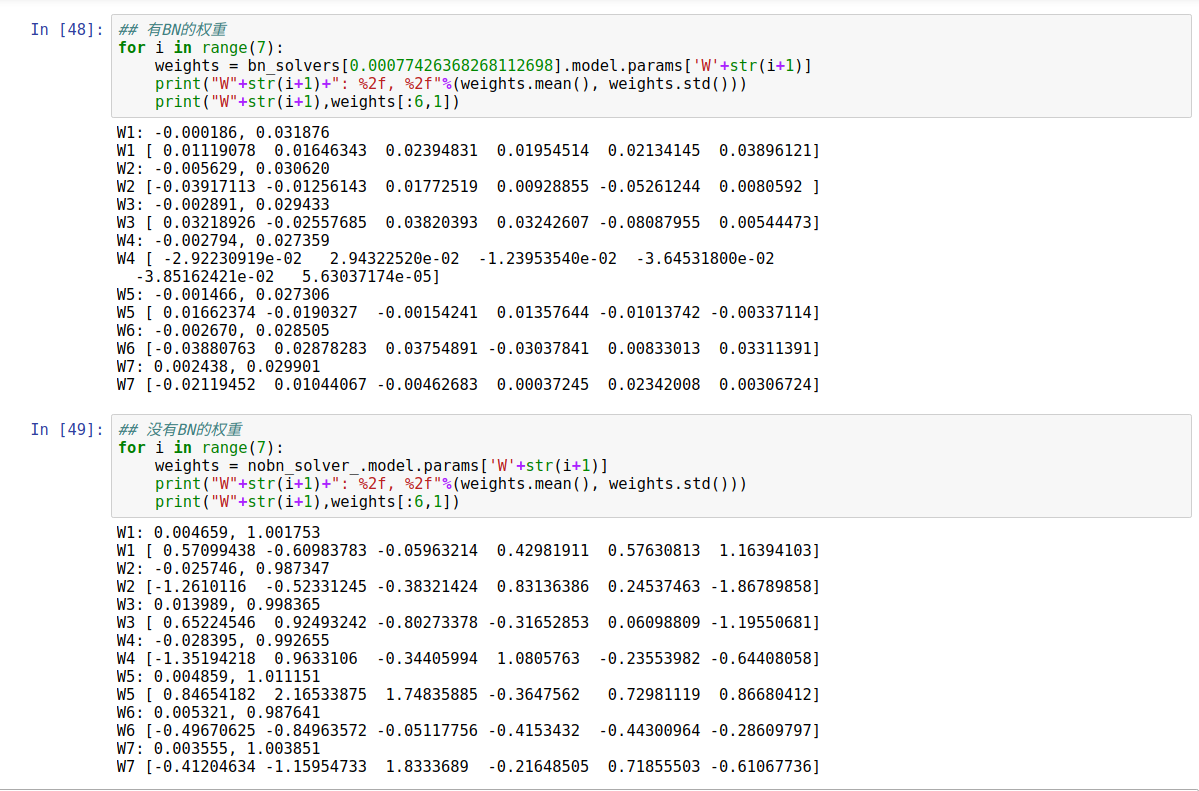
这是只有6层的神经网络,在没有BN的情况下,相比有BN的情况,权重的均值表现还好,但方差会很大.
当神经网络很深时,BN很好的解决了梯度弥散或梯度爆炸出现的问题.

知乎上第二个回答正好给出了公式推导了BN解决梯度弥散的情况.

#### BN前向和反向传播代码实现
```python
def batchnorm_forward(x, gamma, beta, bn_param):
    """
    Forward pass for batch normalization.

    During training the sample mean and (uncorrected) sample variance are
    computed from minibatch statistics and used to normalize the incoming data.
    During training we also keep an exponentially decaying running mean of the
    mean and variance of each feature, and these averages are used to normalize
    data at test-time.              ### 在测试集进行计算时,使用训练集中的移动平均的平均值和方差

    At each timestep we update the running averages for mean and variance using
    an exponential decay based on the momentum parameter:

    running_mean = momentum * running_mean + (1 - momentum) * sample_mean  
    running_var = momentum * running_var + (1 - momentum) * sample_var

    Note that the batch normalization paper suggests a different test-time
    behavior: they compute sample mean and variance for each feature using a
    large number of training images rather than using a running average. For
    this implementation we have chosen to use running averages instead since
    they do not require an additional estimation step; the torch7
    implementation of batch normalization also uses running averages.   ##有用大量样本平均值的,也有用移动平均的.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)    # 控制下一层输入数据的分布
    - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required     ## 包含训练和测试,两种是不同的情况哦~
      - eps: Constant for numeric stability   ## 保证数值稳定性,分母不为0
      - momentum: Constant for running mean / variance.   ## 均值和方差求移动平均时的\beta
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features   ## 方差

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)

    N, D = x.shape
    running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == 'train':
        #######################################################################
        # TODO: Implement the training-time forward pass for batch norm.      #
        # Use minibatch statistics to compute the mean and variance, use      #
        # these statistics to normalize the incoming data, and scale and      #
        # shift the normalized data using gamma and beta.                     #
        #                                                                     #
        # You should store the output in the variable out. Any intermediates  #
        # that you need for the backward pass should be stored in the cache   #
        # variable.                                                           #
        #                                                                     #
        # You should also use your computed sample mean and variance together #
        # with the momentum variable to update the running mean and running   #
        # variance, storing your result in the running_mean and running_var   #
        # variables.                                                          #
        #######################################################################
        sample_mean = np.mean(x, axis=0)
        sample_var = np.mean((x - sample_mean)**2, axis=0)
        sample_norm = (x - sample_mean)/(np.sqrt(sample_var + eps))
        running_mean = momentum * running_mean + (1 - momentum) * sample_mean
        running_var = momentum * running_var + (1 - momentum) * sample_var
        out = gamma * sample_norm + beta            ## (D,)*(N,D) 点乘,broadcasting
        cache = (x, sample_mean, sample_var, sample_norm, eps, gamma, beta)
        #######################################################################
        #                           END OF YOUR CODE                          #
        #######################################################################
    elif mode == 'test':
        #######################################################################
        # TODO: Implement the test-time forward pass for batch normalization. #
        # Use the running mean and variance to normalize the incoming data,   #
        # then scale and shift the normalized data using gamma and beta.      #
        # Store the result in the out variable.                               #
        #######################################################################
        out = gamma * (x - running_mean) / np.sqrt(running_var + eps) + beta 
        #######################################################################
        #                          END OF YOUR CODE                           #
        #######################################################################
    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param['running_mean'] = running_mean ## {affine-[batch norm]-relu-[dropout]}x(L - 1)-affine-softmax
    bn_param['running_var'] = running_var     ##怎么知道哪一层对应的均值是啥?

    return out, cache


def batchnorm_backward(dout, cache):
    """
    Backward pass for batch normalization.

    For this implementation, you should write out a computation graph for
    batch normalization on paper and propagate gradients backward through
    intermediate nodes.

    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from batchnorm_forward.

    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    dx, dgamma, dbeta = None, None, None
    ###########################################################################
    # TODO: Implement the backward pass for batch normalization. Store the    #
    # results in the dx, dgamma, and dbeta variables.                         #
    ###########################################################################
    (x, sample_mean, sample_var, sample_norm, eps, gamma, beta) = cache
    N = dout.shape[0]
    dx_norm = dout * gamma              #(N,D)
    dx_mean = np.sum(dx_norm*(-1/np.sqrt(sample_var + eps)), axis=0)   #(D,)
    dx_var = np.sum(dx_norm*(x-sample_mean)*(-0.5*(1/sample_var)**(-1.5)), axis=0)   #(D,)
    dx = dx_norm*(1/np.sqrt(sample_var + eps)) + dx_mean*1/N + dx_var*2*(x-sample_mean)/N   #(N,D)  
    dgamma = np.sum(dout*sample_norm, axis=0)
    dbeta = np.sum(dout, axis=0)   ## 为什么不除样本数???? 因为在计算out的时候实际上归一化就是除了样本数了的?
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return dx, dgamma, dbeta

```